# Ch02 ETF Trick

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt

import datetime as dt
from adv_finance import bars, labeling, utils, sampling, multiprocess

from tqdm import tqdm
from scipy.sparse import csr_matrix

import matplotlib.pylab as plt
import scipy.sparse as sparse



In [2]:
%load_ext autoreload 
%autoreload 2

plt.style.use('seaborn-talk')
plt.style.use('bmh')
pd.set_option('display.max_rows', 100)


In [7]:
def generate_cov_mat(row): 
    """
    Forms covariance matrix from current data frame row using 'rolling_cov', 
    'rolling_spx_var', and 'rolling_eur_var' column values
    """
    cov = row['rolling_cov']
    spx_var = row['rolling_spx_var']
    euro_var = row['rolling_euro_var']
    return np.matrix([[spx_var, cov], [cov, euro_var]])
    

In [9]:
# Snippet 2.1 from a book 
def pca_weights(cov, riskDist=None, risk_target=1.): 
    """
    Calculates hedging weights using covariance matrix(cov), risk distribution(riskDist) and risk_target
    """
    eVal, eVec = np.linalg.eigh(cov) 
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices], eVec[:, indices]
    if riskDist is None: 
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1.
    loads = risk_target * (riskDist/eVal)**.5
    wghts = np.dot(eVec, np.reshape(loads, (-1, 1)))
    return wghts
    
    

## Data Preprocessing

In [11]:
spx = pd.read_csv('./Sample-Data/spx.csv', usecols=['Date', 'Price', 'Open'])
euro = pd.read_csv('./Sample-Data/eurostoxx.csv', usecols=['Date', 'Price', 'Open'])
eur_usd = pd.read_csv('./Sample-Data/eur_usd.csv', usecols = ['Date', 'Price'])

In [13]:
# rename columns to universal format
spx.rename(columns = {'Date': 'date', 'Price': 'close', 'Open': 'open'}, inplace=True) 
euro.rename(columns = {'Date': 'date', 'Price': 'close', 'Open': 'open'}, inplace=True)
eur_usd.rename(columns = {'Date': 'date', 'Price': 'close'}, inplace=True)

In [14]:
spx['date'] = pd.to_datetime(spx.date) #convert date column to datetime format
euro['date'] = pd.to_datetime(euro.date)
eur_usd['date'] = pd.to_datetime(eur_usd.date)

In [15]:
# convert price data from strings to float (investing.com uses specific decimal sep format)
spx.close = spx.close.apply(lambda x: x.replace(',', '')).astype(float)
euro.close = euro.close.apply(lambda x: x.replace(',', '')).astype(float)
spx.open = spx.open.apply(lambda x: x.replace(',', '')).astype(float)
euro.open = euro.open.apply(lambda x: x.replace(',', '')).astype(float)

In [16]:
spx.set_index('date', inplace=True)
euro.set_index('date', inplace=True)
eur_usd.set_index('date', inplace=True)

In [17]:
spx.sort_index(inplace=True)
euro.sort_index(inplace=True)
eur_usd.sort_index(inplace=True)

In [18]:
eur_usd = eur_usd[eur_usd.index.isin(spx.index)] # exchange rate is needed only for dates when futures are traded

## Generate covariances and hedging weights

In [19]:
cov_df = pd.DataFrame(index=spx.index)  # init data frame with covariance and price data

In [23]:
cov_df.loc[spx.index, 'spx_close'] = spx.loc[:, 'close']
cov_df.loc[euro.index, 'euro_close'] = euro.loc[:, 'close']
cov_df.loc[spx.index, 'spx_open'] = spx.loc[:, 'open']
cov_df.loc[euro.index, 'euro_open'] = euro.loc[:, 'open']
cov_df.loc[eur_usd.index, 'eur_usd'] = eur_usd.loc[:, 'close']
cov_df['euro_fx_adj'] = cov_df.euro_close / cov_df.eur_usd # we need to calculate EUROSTOXX returns adjusted for FX rate
cov_df['spx'] = cov_df.spx_close.pct_change().fillna(0)
cov_df['euro'] = cov_df.euro_fx_adj.pct_change().fillna(0)


In [26]:
# fill missing values with previous ones
cov_df.update(cov_df.loc[:, ['spx', 'euro', 'spx_close', 'spx_open', 'euro_close', 'euro_open', 'eur_usd']].fillna(method='pad'))

In [27]:
cov_df.sort_index(inplace=True)

In [29]:
# get 252 rolling covariance between SPY and EUROSTOXX, rolling variances
cov_df['rolling_cov'] = cov_df['spx'].rolling(window=252).cov(cov_df['euro']) 
cov_df['rolling_spx_var'] = cov_df['spx'].rolling(window=252).var()
cov_df['rolling_euro_var'] = cov_df['euro'].rolling(window=252).var()


In [54]:
cov_df0 = cov_df[:5]

In [108]:
# for i, r in cov_df0.iterrows():
# #     cov = row['rolling_cov']
# #     spx_var = row['rolling_spx_var']
# #     euro_var = row['rolling_euro_var']
# #     m0 = np.matrix([[spx_var, cov], [cov, euro_var]])
#     mat = generate_cov_mat(r)
#     w = pca_weights(mat)
#     print(i)
#     print(mat)
#     print(w)
    
    

In [101]:
# iterate over cov_df and on each step define hedging weights using pca_weights function
cov_df.dropna(inplace=True)
for index, row in cov_df.iterrows():
    mat = generate_cov_mat(row)
    w = pca_weights(mat)
    cov_df.loc[index, 'spx_w'] = w[0]
    cov_df.loc[index, 'euro_w'] = w[1]

    

In [102]:
cov_df.head()

,spx_close,euro_close,spx_open,euro_open,eur_usd,euro_fx_adj,spx,euro,rolling_cov,rolling_spx_var,rolling_euro_var,spx_w,euro_w
date,,,,,,,,,,,,,
2017-02-17,2348.00,3301.0,2345.00,3309.0,1.0614,3110.043339,0.001066,0.003525,0.000046,0.000041,0.000156,-188.632134,65.692558
2017-02-20,2353.25,3314.0,2347.25,3325.0,1.0614,3122.291313,0.002449,0.003938,0.000046,0.000041,0.000156,-188.657776,65.667535
2017-02-21,2360.00,3337.0,2346.50,3315.0,1.0537,3166.935560,0.002868,0.014299,0.000046,0.000041,0.000153,-189.382575,67.178837
2017-02-22,2361.00,3338.0,2360.00,3344.0,1.0556,3162.182645,0.000424,-0.001501,0.000044,0.000040,0.000149,-189.767408,66.602665
2017-02-23,2362.75,3330.0,2362.00,3341.0,1.0581,3147.150553,0.000741,-0.004754,0.000044,0.000040,0.000149,-189.950333,66.836751


## Prepare data set for ETF trick 


In [32]:
open_df = cov_df[['spx_open', 'euro_open']] # create open_df
open_df.rename(columns = {'spx_open': 'spx', 'euro_open': 'euro'}, inplace=True)

/opt/conda/envs/python372/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [33]:
close_df = cov_df[['spx_close', 'euro_close']] # create close_df
close_df.rename(columns = {'spx_close': 'spx', 'euro_close': 'euro'}, inplace=True)

/opt/conda/envs/python372/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [34]:
rates_df = 1/cov_df[['eur_usd']] # we need USD_EUR = 1/EUR_USD rate for EUROSTOXX price movements
rates_df.rename(columns = {'eur_usd': 'euro'}, inplace=True)
rates_df['spx'] = 1.0

In [35]:
alloc_df = cov_df[['spx_w', 'euro_w']] # allocations data frame with weights generated using pca_weights()
alloc_df.rename(columns={'spx_w': 'spx', 'euro_w': 'euro'}, inplace=True)

/opt/conda/envs/python372/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [36]:
costs_df = alloc_df.copy() # let's assume zero rebalancing costs
costs_df['spx'] = 0.0
costs_df['euro'] = 0.0

In [39]:
# open_df: 시가 
# close_df: 종가 

# alloc_df: 할당량?
# alloc_df = cov_df[['spx_w', 'euro_w']] # allocations data frame with weights generated using pca_weights()

# costs_df: rebalancing costs 
# costs_df = alloc_df.copy() # let's assume zero rebalancing costs

# rates_df: 비율???
# rates_df = 1/cov_df[['eur_usd']] # we need USD_EUR = 1/EUR_USD rate for EUROSTOXX price movements



trick = ETFTrick(open_df, close_df, alloc_df,
                costs_df, rates_df, in_memory=True) # in_memory means that all data frames are stored in memory, if False open_df should be a path to open data frame

In [40]:
trick_series = trick.get_etf_series()

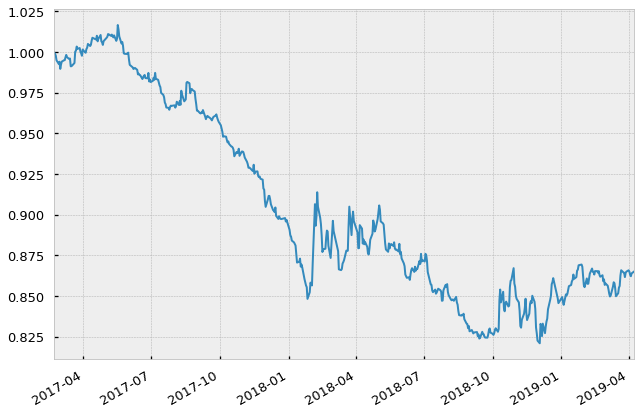

In [41]:
trick_series.plot()

# APPENDIX

## ETF Trick Implementation

In [47]:

"""
This module contains class for ETF trick generation and futures roll function, described in
Marcos Lopez de Prado book 'Advances in Financial Machine Learning'
ETF trick class can generate ETF trick series either from .csv files or from in memory pandas
data frames
"""

# Imports
import pandas as pd
import numpy as np


class ETFTrick:
    """
    Contains logic of vectorised ETF trick implementaion. Can used for both memory data frames (pd.DataFrame) and csv files.
    All data frames, files should be processed in a specific format, described in examples
    """

    def __init__(self, open_df, close_df, alloc_df, costs_df, rates_df=None, in_memory=True, batch_size=5000, index_col=0):
        """
        Constructor
        Creates class object, for csv based files reads the first data chunk.
        :param open_df: (pd.DataFrame or string): open prices data frame or path to csv file
        :param close_df: (pd.DataFrame or string): close prices data frame or path to csv file
        :param alloc_df: (pd.DataFrame or string): asset allocations data frame or path to csv file (in # of contracts)
        :param costs_df: (pd.DataFrame or string): rebalance, carry and dividend costs of holding/rebalancing the position
        :param rates_df: (pd.DataFrame or string): dollar value of one point move of contract(includes exchange rate, futures contracts multiplies).
                         For example, 1$ in VIX index, equals 1000$ in VIX futures contract value. If None then trivial (all values equal 1.0) is generated
        :param in_memory: (boolean): boolean flag of whether data frames are stored in memory or in csv files
        :param batch_size: (int): number of rows to per batch. Used for csv stored data frames
        :param index_col: (int): positional index of index column. Used for to determine index column in csv files

        """
        self.in_memory = in_memory
        self.batch_size = batch_size
        self.index_col = index_col
        self.prev_k = 1.0  # init with 1$ as initial value
        # we need to track allocations vector change on previous step
        # previous allocation change is needede for delta component calculation
        self.prev_allocs_change = False

        if in_memory is False:
            # create file iterators
            self.open_iter = pd.read_csv(
                open_df, iterator=True, index_col=self.index_col, parse_dates=[self.index_col])
            self.close_iter = pd.read_csv(
                close_df, iterator=True, index_col=self.index_col, parse_dates=[self.index_col])
            self.alloc_iter = pd.read_csv(
                alloc_df, iterator=True, index_col=self.index_col, parse_dates=[self.index_col])
            self.costs_iter = pd.read_csv(
                costs_df, iterator=True, index_col=self.index_col, parse_dates=[self.index_col])

            # get initial data chunk from file iterator
            open_df = self.open_iter.get_chunk(self.batch_size)
            close_df = self.close_iter.get_chunk(self.batch_size)
            alloc_df = self.alloc_iter.get_chunk(self.batch_size)
            costs_df = self.costs_iter.get_chunk(self.batch_size)

            if rates_df is not None:
                self.rates_iter = pd.read_csv(
                    rates_df, iterator=True, index_col=self.index_col, parse_dates=[self.index_col])
                rates_df = self.rates_iter.get_chunk(batch_size)

        self.securities = alloc_df.columns  # get all securities columns
        if rates_df is None:
            rates_df = open_df.copy()
            # set trivial(1.0) exchange rate if no data is provided
            rates_df[self.securities] = 1.0

        # align all securities columns in one order
        open_df = open_df[self.securities]
        close_df = close_df[self.securities]
        alloc_df = alloc_df[self.securities]
        costs_df = costs_df[self.securities]
        rates_df = rates_df[self.securities]

        self.cache = {'open': open_df.iloc[-2:], 'close': close_df.iloc[-2:], 'alloc': alloc_df.iloc[-2:], 'costs': costs_df.iloc[-2:],
                      'rates': rates_df.iloc[-2:]}  # cache is used to recalculate previous row after next chunk load

        # check if all data frames have the same index
        for df in [close_df, alloc_df, costs_df, rates_df]:
            if open_df.index.difference(df.index).shape[0] != 0:
                raise ValueError('DataFrames indices are different')

        self.data_df = self.generate_trick_components(
            open_df, close_df, alloc_df, costs_df, rates_df)  # get all possible etf trick calculations which can be vectorised
        # delete first nans (first row of close price difference is nan)
        self.data_df = self.data_df.iloc[1:]
        self.prev_allocs = np.array(
            [np.nan for _ in range(0, len(self.securities))])  # init weights with nan values

        self.prev_h = None  # to find current etf_trick value we need previous h value

    def generate_trick_components(self, open_df, close_df, alloc_df, costs_df, rates_df):
        """
        Calculates all etf trick operations which can be vectorised. Outputs multilevel pandas data frame.
        Generated components:
        'w': alloc_df
        'h_t': h_t/K value from ETF trick algorithm from the book. Which K to use is based on previous values and cannot be vectorised
        'close_open': close_df - open_df
        'price_diff': close price differences
        'costs': costs_df
        'rate': rates_df
        :param open_df: (pd.DataFrame or string): open prices data frame or path to csv file
        :param close_df: (pd.DataFrame or string): close prices data frame or path to csv file
        :param alloc_df: (pd.DataFrame or string): asset allocations data frame or path to csv file (in # of contracts)
        :param costs_df: (pd.DataFrame or string): rebalance, carry and dividend costs of holding/rebalancing the position
        :param rates_df: (pd.DataFrame or string): dollar value of one point move of contract(includes exchange rate, futures contracts multiplies).
                         For example, 1$ in VIX index, equals 1000$ in VIX futures contract value. If None then trivial (all values equal 1.0) is generated
        :return: (pd.DataFrame): pandas data frame with columns in a format: component_1/asset_name_1, component_1/asset_name_2, ..., component_6/asset_name_n
        """
        if self.in_memory is False:
            max_prev_index = self.cache['open'].index.max() # latest index from previous data_df(cache)
            second_max_prev_index = self.cache['open'].index[-2]
            # add the last row from previous data chunk to a new chunk
            open_df.loc[max_prev_index, :] = self.cache['open'].iloc[-1]
            close_df.loc[max_prev_index, :] = self.cache['close'].iloc[-1]
            alloc_df.loc[max_prev_index, :] = self.cache['alloc'].iloc[-1]
            costs_df.loc[max_prev_index, :] = self.cache['costs'].iloc[-1]
            rates_df.loc[max_prev_index, :] = self.cache['rates'].iloc[-1]

            # to recalculate latest row we need close price differences
            close_df.loc[second_max_prev_index,
                         :] = self.cache['close'].loc[second_max_prev_index, :]
            # that is why close_df needs 2 previous chunk rows to omit first row nans
            # sort data frames after all appends
            open_df.sort_index(inplace=True)
            close_df.sort_index(inplace=True)
            alloc_df.sort_index(inplace=True)
            costs_df.sort_index(inplace=True)
            rates_df.sort_index(inplace=True)

            # align all securities columns in one order
            open_df = open_df[self.securities]
            close_df = close_df[self.securities]
            alloc_df = alloc_df[self.securities]
            costs_df = costs_df[self.securities]
            rates_df = rates_df[self.securities]

            # get price diffs, take values from the second row (first is nan)
            price_diff = close_df.diff().iloc[1:]
            # delete second max row from previous data chunk in close_df
            close_df = close_df.iloc[1:]
        else:
            price_diff = close_df.diff()

        next_open_df = open_df.shift(-1)  # generate next open prices
        close_open_diff = close_df.sub(open_df)  # close - open data frame
        alloc_df['abs_w_sum'] = alloc_df.abs().sum(
            axis=1)  # for each row generate absolute values sum for all assets
        delever_df = (next_open_df.mul(rates_df)).mul(
            alloc_df['abs_w_sum'], axis='index')  # deleverage component for h_i_t calculation
        h_without_k = alloc_df.div(
            delever_df)  # generate calculated h_t values for each row. For complete h_t calculation multiplying by current K_t is needed(can be vectorised)

        weights_df = alloc_df[self.securities]  # allign all securities columns
        h_without_k = h_without_k[self.securities]
        close_open_diff = close_open_diff[self.securities]
        price_diff = price_diff[self.securities]
        costs_df = costs_df[self.securities]
        rates_df = rates_df[self.securities]

        return pd.concat([weights_df, h_without_k, close_open_diff, price_diff, costs_df, rates_df], axis=1,
                         keys=[
            'w', 'h_t', 'close_open', 'price_diff', 'costs',
            'rate'])  # generate data frame with all pregenerated info needed for ETF trick

    def _chunk_loop(self):
        """
        Single ETF trick iteration for currently stored data set in memory.
        For in-memory data set would yield complete ETF trick series, for csv based
        would generate ETF trick series for current batch.
        :return: (pd.Series): pandas Series with ETF trick values starting from 1.0
        """
        etf_series = pd.Series()
        for index, row in zip(self.data_df.index, self.data_df.values):
            weights_arr, h_t, close_open, price_diff, costs, rate = np.array_split(
                row, 6)  # split row in corresponding values for ETF trick
            # replaces nan to zeros in allocations vector
            weights_arr = np.nan_to_num(weights_arr)
            # convert np.bool to bool
            # boolean flag of allocations vector change
            allocs_change = bool(~(self.prev_allocs == weights_arr).all())
            if self.prev_allocs_change is True:
                delta = close_open  # delta from book algorithm
            else:
                delta = price_diff
            if self.prev_h is None:
                # previous h value is needed for current K calculation. The first iteration sets up prev_h value
                self.prev_h = h_t * self.prev_k
                # K is equal to 1 on the first iteration
                etf_series[index] = self.prev_k
            else:
                k = self.prev_k + \
                    np.nansum(self.prev_h * rate * (delta + costs))
                etf_series[index] = k
                self.prev_k = k
                if allocs_change == True:
                    # h_t is equal to previous h_t, or h_t * k if allocations vector changes (roll dates)
                    self.prev_h = h_t * k
                # update previous allocation vector change
                self.prev_allocs_change = allocs_change
                self.prev_allocs = weights_arr
        return etf_series

    def _csv_file_etf_series(self):
        """
        Csv based ETF trick series generation
        :return: (pd.Series): pandas Series with ETF trick values starting from 1.0
        """
        etf_series = pd.Series()
        # read data in batch until StopIteration exception is raised
        while True:
            try:
                # generate ETF trick values for read data chunk
                chunk_etf_series = self._chunk_loop()
                etf_series = etf_series.append(chunk_etf_series)
                open_df = self.open_iter.get_chunk(
                    self.batch_size)  # read the next batch
                close_df = self.close_iter.get_chunk(self.batch_size)
                alloc_df = self.alloc_iter.get_chunk(self.batch_size)
                costs_df = self.costs_iter.get_chunk(self.batch_size)

                try:
                    # if there is rates_df iterator, get the next chunk
                    rates_df = self.rates_iter.get_chunk(self.batch_size)
                except AttributeError:
                    # if no iterator is available, generate trivial ratest_df (1.0 for all securities)
                    rates_df = open_df.copy()
                    # set trivial(1.0) exchange rate if no data is provided
                    rates_df[self.securities] = 1.0

                next_data_df = self.generate_trick_components(
                    open_df, close_df, alloc_df, costs_df, rates_df)
                self.cache = {'open': open_df.iloc[-2:], 'close': close_df.iloc[-2:], 'alloc': alloc_df.iloc[-2:],
                              'costs': costs_df.iloc[-2:],
                              'rates': rates_df.iloc[-2:]}  # update cache
                next_data_df.sort_index(inplace=True)
                self.data_df = next_data_df  # update data_df for ETF trick calculation
                # reset prev_k for previous row calculation
                self.prev_k = etf_series.iloc[-2]
            except StopIteration:
                return etf_series

    def _in_memory_etf_series(self):
        """
        In-memory based ETF trick series generation
        :return: (pd.Series): pandas Series with ETF trick values starting from 1.0
        """
        return self._chunk_loop()

    def get_etf_series(self):
        """
        External method which defines which etf trick method to use based on in_memory field value
        :return: (pd.Series): pandas Series with ETF trick values starting from 1.0
        """
        if self.in_memory is True:
            return self._in_memory_etf_series()
        else:
            return self._csv_file_etf_series()


def get_futures_roll_series(df, open_col, close_col, sec_col, current_sec_col,  roll_backward=False):
    """
    Function for generating rolling futures series from data frame of multiple futures
    :param df: (pd.DataFrame): pandas DataFrame containing price info, security name and  current active futures column
    :param open_col: (string): open prices column name
    :param close_col: (string): close prices column name
    :param sec_col: (string): security name column name
    :param current_sec_col: (string): current active security column name.
                                      When value in this column changes it means rolling
    :param roll_backward: (boolean): True for substracting final gap value from all values
    :return (pd.Series): futures roll close price series
    """
    # filter out security data which is not used as current security
    df = df[df[sec_col] == df[current_sec_col]]
    df.sort_index(inplace=True)
    # generate roll dates series based on curren_sec column value change
    roll_dates = df[current_sec_col].drop_duplicates(keep='first').index
    gaps = df[close_col] * 0  # roll gaps series
    gaps.loc[roll_dates[1:]] = series[open_col].loc[roll_dates[1:]] - \
        series[close_col].loc[roll_dates[1:] # on roll dates, gap equals open - close
                              ]  # TODO: undertand why Marcos used iloc and list logic
    if roll_backward:
        gaps -= gaps.iloc[-1]  # roll backward
    df[close_col] -= gaps
    return df[close_col]
